
In this notebook we are using pytorch-ts for impact estimation of CPH activity in Italy. For training we are using the covariates cph_all and no_cph_all, which denots the sum of either cph or no cph actions. Due to previous findings we apply a mean rolling window of 4 month, because previous actions have an impact on our current month also. We then predict on the next 3 months and our mape is around .22% (and very similar if we are using covariates nor not). Please note that we used basic parameters (batches_per_epochs=128, epochs=64, learning_rate=1e-3) without tuning the model and also only went with 10 epochs. 

In the last step we scaled our cph activity to zero (please note that we also scaled all covariates and the target via a min-max scaler, because this is benefitial for the LSTM model.

Our estimated impact during these three months by comparing our predictions from original covariance values and cph activity = 0 is around 1%. So due to cph activity we gain 1% in sales.

One problem we can observe is that this positive effect is not true for all areas. While we find an overall effect of +1% for many areas we find that using cph actions decreases our sales predictions. As this is a blockbox model, it is hard for us to understand why this is the case. 

There would be many more steps necessary to verify this result and understand why we obtain a negative result for some areas.

At the moment it looks like applying a white box model more similar to a Marketing Mix Model would be a more appropriate approach to understand the impact of cph activity.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

from pts.model.deepar import DeepAREstimator
from pts import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts import time_feature
import json
from itertools import islice
from gluonts.dataset.field_names import FieldName
import numpy as np

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [145]:
model_input = df_asl = pd.read_csv('s3://phmsbi-cpd-analytics-dev/jan_rathfelder/ita/xrlt/impact_attribution.predictive_modeling/model_input_asl_new.csv')

model_input['yyyymm'] = pd.to_datetime(model_input['yyyymm']) 
model_input.shape

(2057, 380)

In [146]:
model_input = model_input[(model_input.asl!='FABRIANO')
               #&(df_asl.region!='VALLE D\'AOSTA')
               # &(df_asl.region!='MARCHE')
               ].copy()

model_input = model_input[(model_input.asl!='ULSS 5 POLESANA')].copy()

In [147]:
model_input.head(2)

,Unnamed: 0,yyyymm,asl,region,num_hcp_asl_mccp,num_hcp_AE_cph,num_AE_cph,num_AE_nocph,num_hcp_NL_cph,num_NL_cph,...,sales_per_hcp_diff,sales_per_hcp_diff_shift1,sales_per_hcp_diff_shift2,sales_per_hcp_diff_shift3,sales_per_hcp_diff_shift4,sales_per_hcp_diff_shift5,sales_per_hcp_diff_shift6,sales_per_hcp_diff_shift7,sales_per_hcp_diff_shift8,sales_per_hcp_diff_shift9
0,0,2020-08-01,ANCONA,MARCHE,121.0,0.041322,0.041322,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-09-01,ANCONA,MARCHE,121.0,0.181818,0.181818,0.0,0.0,0.0,...,56.24793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
features = [
            'yyyymm',
            'asl',
            #'num_cph_visit',    
            'cph_all_1_to_4m_mean',   
            'no_cph_all_1_to_4m_mean',
            'sales_per_hcp'
           ]

In [153]:
df = model_input[features]
df = df.set_index('yyyymm')
df = df.fillna(0)

In [150]:
df = df.sort_values(['asl', 'yyyymm'])

In [154]:
# Normalize input data:
prediction_length = 3

input_cols = [  'cph_all_1_to_4m_mean',   
                'no_cph_all_1_to_4m_mean',
                'sales_per_hcp'
             ]

cut_off_indx = df.index.max()-pd.DateOffset(months=prediction_length)
indx_train = df[df.index<=cut_off_indx].index
indx_test = df[df.index>cut_off_indx].index
for col in input_cols:
    max_temp_train = max(df[df.index.isin(indx_train)][col])
    min_temp_train = min(df[df.index.isin(indx_train)][col])
    
    max_temp_test = max(df[~df.index.isin(indx_train)][col])
    min_temp_test = min(df[~df.index.isin(indx_train)][col])
    
    a = df[df.index.isin(indx_train)][col].apply(lambda x: (
        x-min_temp_train)/(max_temp_train-min_temp_train))
    b = df[~df.index.isin(indx_train)][col].apply(lambda x: (
        x-min_temp_test)/(max_temp_test-min_temp_test))

    c = (a.values,b.values)
    c = np.concatenate(c)

    df['scaled_'+col] = c
    
df.describe()    

,cph_all_1_to_4m_mean,no_cph_all_1_to_4m_mean,sales_per_hcp,scaled_cph_all_1_to_4m_mean,scaled_no_cph_all_1_to_4m_mean,scaled_sales_per_hcp
count,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000
mean,0.475250,0.541056,639.330503,0.164483,0.302207,0.275499
std,0.396449,0.346505,294.390269,0.142064,0.198883,0.161755
min,0.000000,0.000000,128.301808,0.000000,0.000000,0.000000
25%,0.175177,0.312829,458.345193,0.055945,0.163050,0.175808
50%,0.433486,0.575000,557.797104,0.149912,0.319828,0.231726
75%,0.689353,0.772073,718.412652,0.235909,0.427636,0.319760
max,3.385817,1.904762,2029.190796,1.000000,1.000000,1.000000


### Train only with target series

In [155]:
table_target = pd.pivot_table(df, 
                           values='scaled_sales_per_hcp', 
                           index=['asl'],
                           columns=['yyyymm'],
                           aggfunc=np.sum)
table_target['target'] = table_target.apply(lambda x: np.array(x), axis=1)

target = np.array(table_target['target'].tolist())

In [156]:
freq='M'
start = df.index[0]
prediction_length=3

train_ds = ListDataset(
    [{'target': x, 'start': start} for x in target[:, :-prediction_length]],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': x, 'start': start} for x in target],
    freq=freq
)

In [157]:
# returns test and train dict

test_entry = next(iter(test_ds))
train_entry = next(iter(train_ds))

print(train_entry.keys(),
      test_entry.keys())

dict_keys(['target', 'start', 'source']) dict_keys(['target', 'start', 'source'])


In [158]:
# Inspect how train and test dict look:

print(train_entry)
print()
print(test_entry)

{'target': array([0.19853672, 0.22957157, 0.24222079, 0.23660296, 0.26062465,
       0.22234865, 0.20671722, 0.25433195, 0.25257638, 0.23541282,
       0.25865018, 0.27181014, 0.2360193 , 0.2710988 ], dtype=float32), 'start': Timestamp('2020-08-31 00:00:00', freq='M'), 'source': SourceContext(source='list_data', row=0)}

{'target': array([0.19853672, 0.22957157, 0.24222079, 0.23660296, 0.26062465,
       0.22234865, 0.20671722, 0.25433195, 0.25257638, 0.23541282,
       0.25865018, 0.27181014, 0.2360193 , 0.2710988 , 0.13122532,
       0.17723618, 0.18802004], dtype=float32), 'start': Timestamp('2020-08-31 00:00:00', freq='M'), 'source': SourceContext(source='list_data', row=0)}


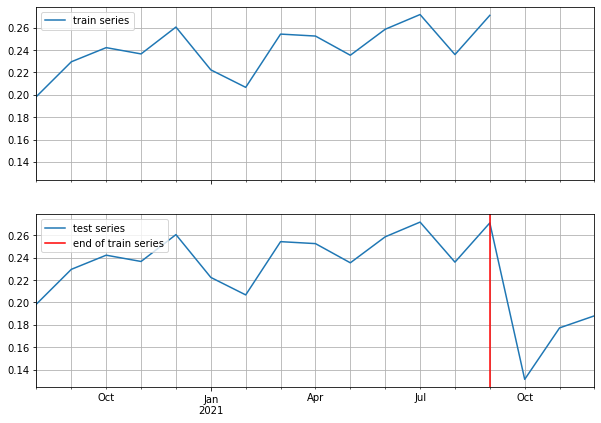

In [159]:
# plot train and testing data:

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [160]:
# Train DeepAR model:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = DeepAREstimator(freq='M',
                            prediction_length=prediction_length,
                            input_size=14,
                            context_length=4*prediction_length,
                            trainer=Trainer(epochs=10,
                                            learning_rate=1e-3,
                                            num_batches_per_epoch=128,
                                            batch_size=64,
                                            device=device))

predictor = estimator.train(training_data=train_ds, 
                            num_workers=0
                           )

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [161]:
# make forecast and compare to observed values:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=50,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 119/119 [00:00<00:00, 802.26it/s]


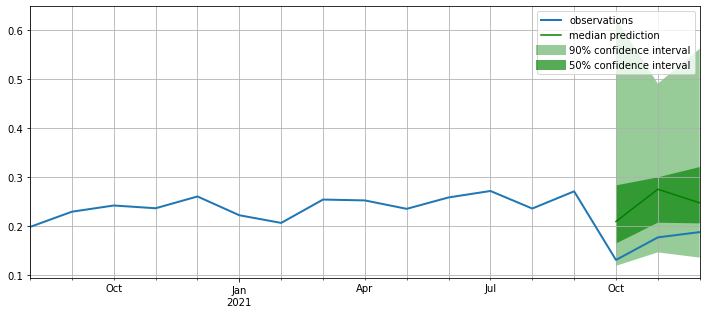

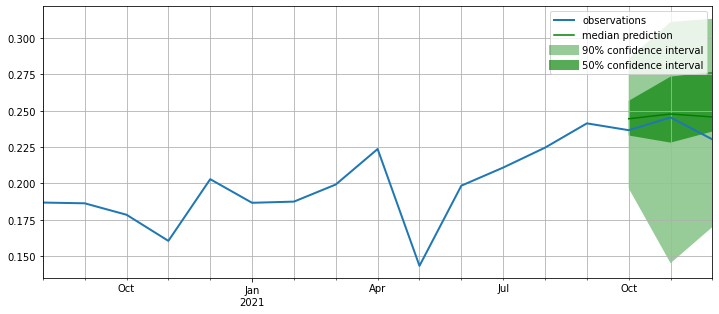

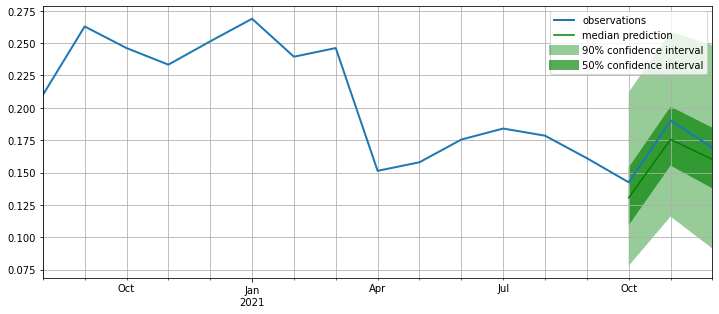

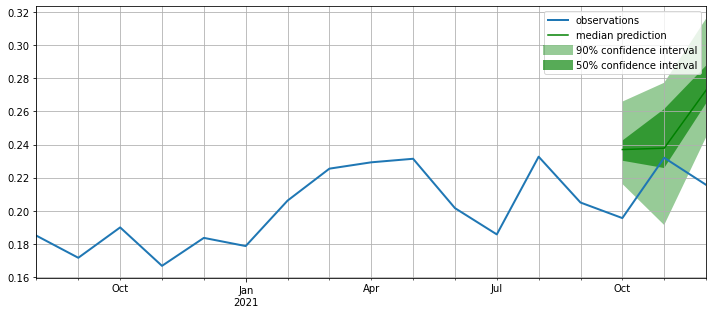

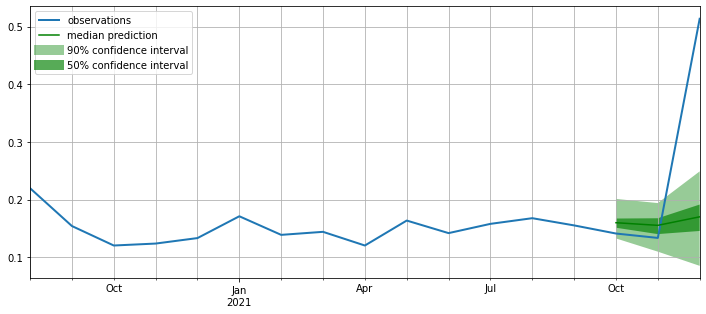

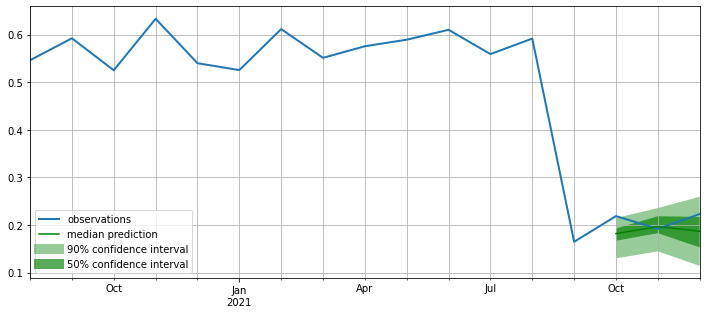

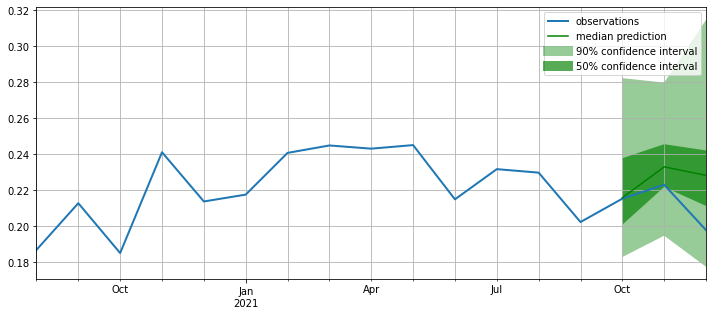

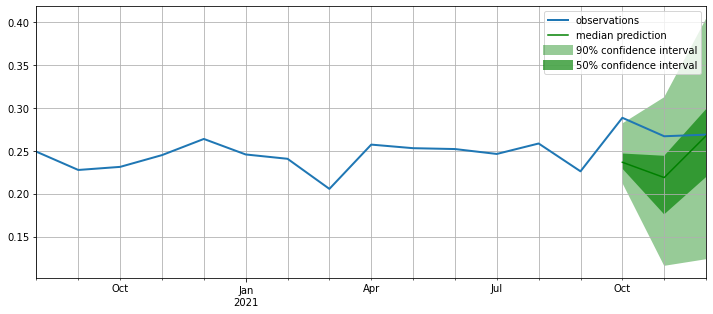

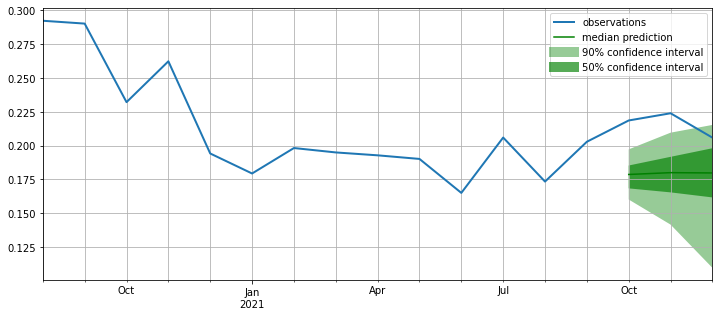

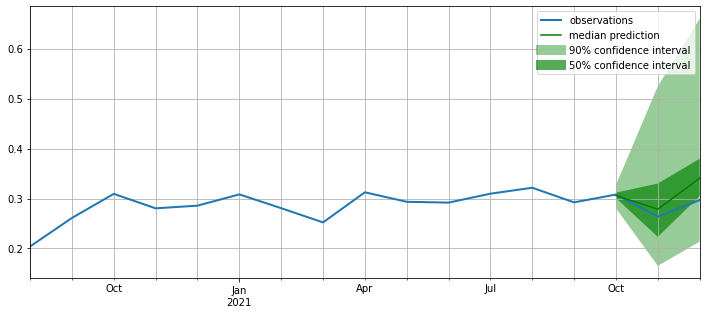

In [162]:
# plot forecast vs true:

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

#num_samples_used_for_ci = 100 # creates n predictions to generate intervall
#forecast_it, ts_it = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=num_samples_used_for_ci)
#forecasts = list(forecast_it)
#tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=150, num_plots=10)

In [163]:
# Print errors:

print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.00757331565039874,
    "abs_error": 17.885654389858246,
    "abs_target_sum": 96.10093599557877,
    "abs_target_mean": 0.2691902969063831,
    "seasonal_error": 0.12003268401662842,
    "MASE": 1.4084021180037938,
    "MAPE": 0.22101474457344755,
    "sMAPE": 0.1967367361865791,
    "MSIS": 15.107894187236758,
    "QuantileLoss[0.1]": 9.239368844777346,
    "Coverage[0.1]": 0.17366946778711484,
    "QuantileLoss[0.2]": 13.323341795802115,
    "Coverage[0.2]": 0.27170868347338933,
    "QuantileLoss[0.3]": 15.783290317282079,
    "Coverage[0.3]": 0.34453781512605053,
    "QuantileLoss[0.4]": 17.340892845392222,
    "Coverage[0.4]": 0.4005602240896359,
    "QuantileLoss[0.5]": 17.885654345154762,
    "Coverage[0.5]": 0.45658263305322133,
    "QuantileLoss[0.6]": 17.997349879890677,
    "Coverage[0.6]": 0.5210084033613445,
    "QuantileLoss[0.7]": 17.204070137441157,
    "Coverage[0.7]": 0.6106442577030814,
    "QuantileLoss[0.8]": 15.563425937294959,
    "Coverage[0.8]": 0

### Train multivariate model

In [164]:
df.isna().sum()

asl                               0
cph_all_1_to_4m_mean              0
no_cph_all_1_to_4m_mean           0
sales_per_hcp                     0
scaled_cph_all_1_to_4m_mean       0
scaled_no_cph_all_1_to_4m_mean    0
scaled_sales_per_hcp              0
dtype: int64

In [165]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': table_target.shape[0],
    'num_steps': table_target.shape[1],
    'prediction_length': 3,
    'freq': 'M',
    'start': [
        pd.Timestamp(df.index.drop_duplicates()[0], freq='M')
        for _ in range(table_target.shape[0])
    ]
}

In [166]:
table_target = pd.pivot_table(df, 
                           values='scaled_sales_per_hcp', 
                           index=['asl'],
                           columns=['yyyymm'],
                           aggfunc=np.sum)
table_target['target'] = table_target.apply(lambda x: np.array(x), axis=1)


In [167]:
target = np.array(table_target['target'].tolist())

In [168]:
features_train = ['scaled_cph_all_1_to_4m_mean',
                  'scaled_no_cph_all_1_to_4m_mean',]

In [169]:
table_target = pd.pivot_table(df, 
                           values=features_train, 
                           index=['asl'],
                           #columns=['yyyymm'],
                           #aggfunc=np.sum
                             )

In [170]:
df_sorted = df.sort_values(['asl', 'yyyymm']).copy()

feat_dynamic_real = [df_sorted[features_train].iloc[:target.shape[1],:].values.T]
ts_length = target.shape[1]
number_ts = target.shape[0]
count = ts_length

for i in range(number_ts-1):
    curr_idx = ts_length
    feat_dynamic_real = np.vstack((feat_dynamic_real, [df_sorted[
                        features_train].iloc[count:(count+ts_length),:].values.T]))
    count += ts_length
    
#feat_dynamic_real_train = stack[:,:,:-custom_ds_metadata['prediction_length']]
#feat_dynamic_real_test = stack

In [171]:
# Define fields used
# Here we define a dynamic_real value on top of the target
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: fdr
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target[:, :-custom_ds_metadata['prediction_length']],
            custom_ds_metadata['start'],
            feat_dynamic_real[:,:,:-custom_ds_metadata['prediction_length']]
            #feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

# test
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: fdr
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real,
            #feat_static_cat
            )
    ],
    freq=custom_ds_metadata['freq']
)

In [172]:
# Returning train and test dict:

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

print(test_entry.keys(), train_entry.keys())

dict_keys(['target', 'start', 'feat_dynamic_real', 'source']) dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])


In [173]:
train_entry['feat_dynamic_real'].shape

(2, 14)

In [174]:
test_entry['feat_dynamic_real'].shape

(2, 17)

In [175]:
from gluonts import transform

In [176]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
    AddAggregateLags,
    AddConstFeature,
    AddTimeFeatures,
    cdf_to_gaussian_forward_transform,
    BucketInstanceSampler
)

def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
                imputation_method=transform.MissingValueImputation(),
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=custom_ds_metadata['prediction_length'],
                log_scale=True,
            ),
            #AddConstFeature(
            #output_field=FieldName.FEAT_CONST,
            #target_field=FieldName.TARGET,
            #pred_length=custom_ds_metadata['prediction_length'],
            #const=1.0
            #),
            AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            time_features=[time_feature.MonthOfYearIndex()],
            pred_length=custom_ds_metadata['prediction_length']
            ),
        ]
    )

In [177]:
transformation = create_transformation(
    custom_ds_metadata['freq'],
    1 * custom_ds_metadata['prediction_length'], # can be any appropriate value
    custom_ds_metadata['prediction_length']
)

train_tf = transformation(iter(train_ds), is_train=True)
test_tf = transformation(iter(test_ds), is_train=False)

print(type(train_tf))
print(transformation.transformations)

<class 'generator'>
[gluonts.transform.feature.AddObservedValuesIndicator(imputation_method=gluonts.transform.feature.MissingValueImputation(), output_field="observed_values", target_field="target"), gluonts.transform.feature.AddAgeFeature(log_scale=True, output_field="feat_dynamic_age", pred_length=3, target_field="target"), gluonts.transform.feature.AddTimeFeatures(output_field="time_feat", pred_length=3, start_field="start", target_field="target", time_features=[gluonts.time_feature._base.MonthOfYearIndex()])]


In [178]:
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

['target',
 'start',
 'feat_dynamic_real',
 'source',
 'observed_values',
 'feat_dynamic_age',
 'time_feat']

In [179]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = DeepAREstimator(freq=custom_ds_metadata['freq'],
                            prediction_length=custom_ds_metadata['prediction_length'],
                            input_size=16,
                            num_layers=2,
                            use_feat_dynamic_real=True,
                            context_length=4*custom_ds_metadata['prediction_length'],
                            #distr_output = NegativeBinomialOutput(),
                            #context_length=4*custom_ds_metadata['prediction_length'],
                            #use_feat_static_cat=True,
                            trainer=Trainer(epochs=10,
                                            learning_rate=1e-3,
                                            num_batches_per_epoch=128,
                                            batch_size=64,
                                            device=device))

predictor = estimator.train(training_data=train_ds, 
                            num_workers=0
                           )

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [180]:
# Return forcast and compare with true values:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 119/119 [00:00<00:00, 804.96it/s]


In [181]:
print(predictor.input_names)
print()
print(estimator.time_features)
print()
print(predictor.freq)
print()
print(estimator.use_feat_dynamic_real)

['feat_static_cat', 'feat_static_real', 'past_time_feat', 'past_target', 'past_observed_values', 'future_time_feat']

[gluonts.time_feature._base.MonthOfYear()]

M

True


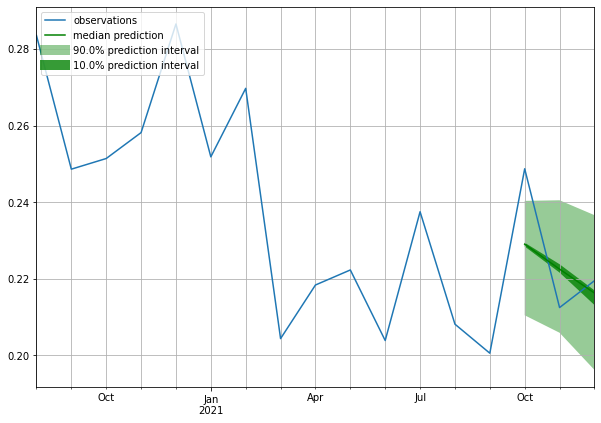

In [182]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (10.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

id_random = np.random.choice(len(test_ds))
#id_random=1
forecast_entry = forecasts[id_random]
ts_entry = tss[id_random]
plot_prob_forecasts(ts_entry, forecast_entry) 

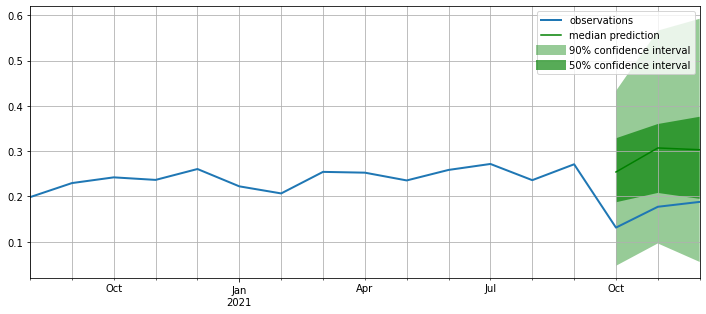

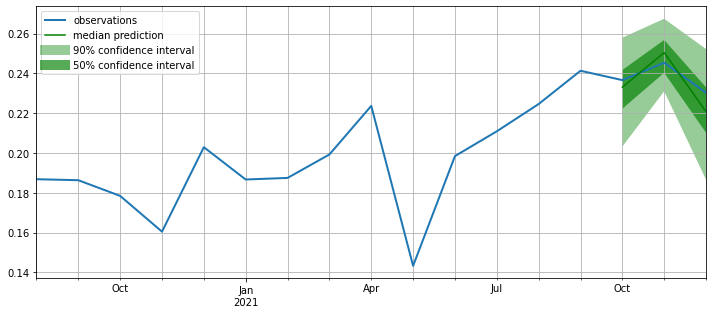

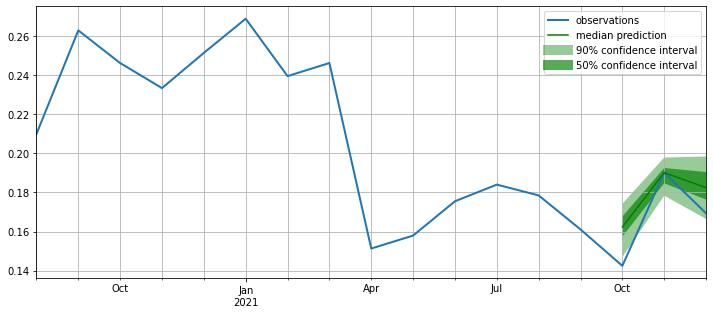

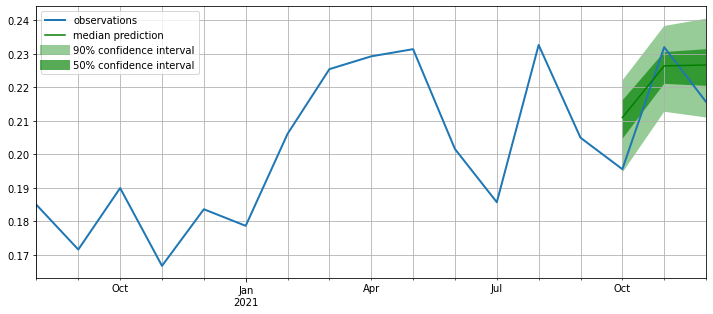

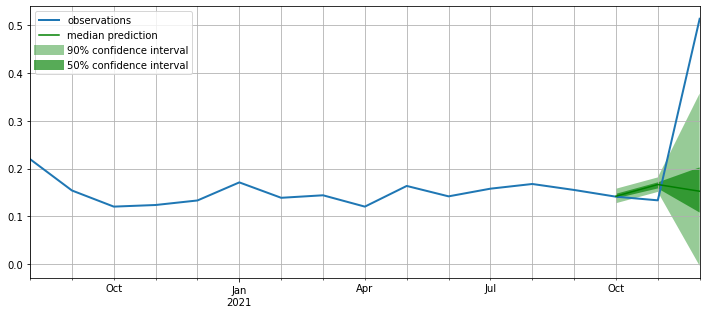

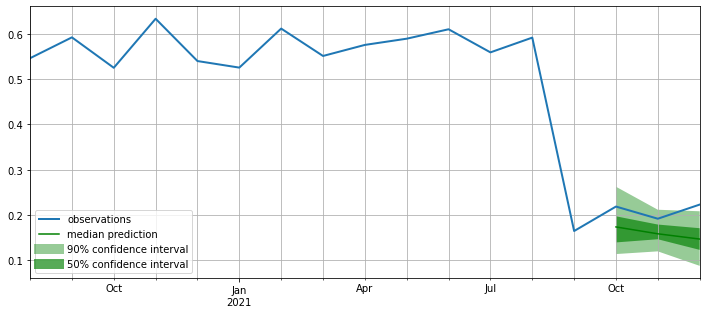

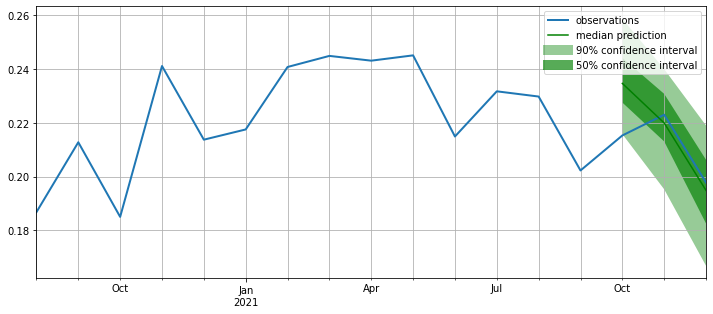

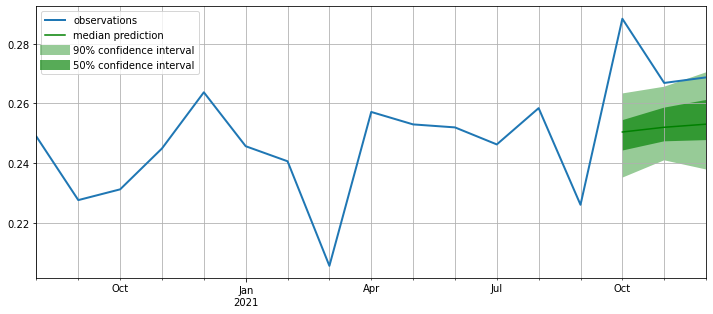

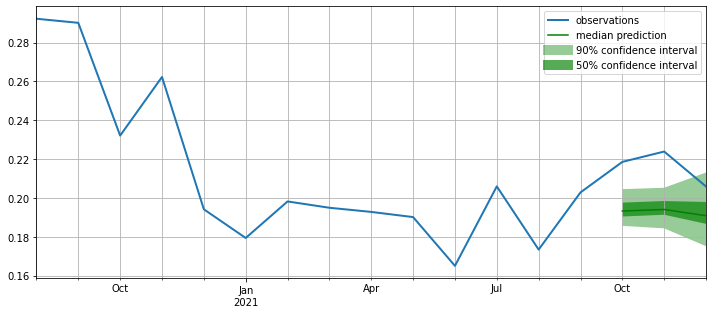

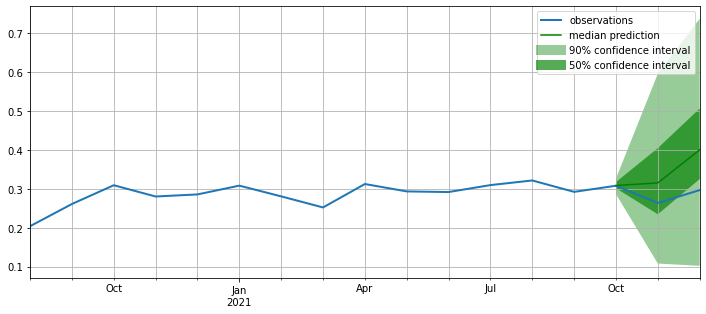

In [183]:
# Compare forecast vs true

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

#forecast_it, ts_it = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=100)
#forecasts = list(forecast_it)
#tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=150, num_plots=10)

In [184]:
# Print errors:

print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.006321238273283023,
    "abs_error": 15.918073670938611,
    "abs_target_sum": 96.10093599557877,
    "abs_target_mean": 0.2691902969063831,
    "seasonal_error": 0.12003268401662842,
    "MASE": 1.2836757248914936,
    "MAPE": 0.21158727502622524,
    "sMAPE": 0.18416748281453507,
    "MSIS": 8.689644858428354,
    "QuantileLoss[0.1]": 5.657474840804936,
    "Coverage[0.1]": 0.10644257703081232,
    "QuantileLoss[0.2]": 9.629748509824276,
    "Coverage[0.2]": 0.24929971988795516,
    "QuantileLoss[0.3]": 12.862882639467715,
    "Coverage[0.3]": 0.3445378151260504,
    "QuantileLoss[0.4]": 14.96966219395399,
    "Coverage[0.4]": 0.39215686274509803,
    "QuantileLoss[0.5]": 15.918073674663901,
    "Coverage[0.5]": 0.45098039215686275,
    "QuantileLoss[0.6]": 16.17438272461295,
    "Coverage[0.6]": 0.5182072829131652,
    "QuantileLoss[0.7]": 15.828271657973527,
    "Coverage[0.7]": 0.6022408963585435,
    "QuantileLoss[0.8]": 14.096425780653956,
    "Coverage[0.8]": 0.6

In [185]:
fc_means = [forecasts[i].mean for i in range(len(forecasts))]
fc_means = np.concatenate(fc_means)

In [186]:
# change input for prediction:

feat_dynamic_real[:,0,(ts_length-custom_ds_metadata['prediction_length']):]=0

# test
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: fdr
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real,
            #feat_static_cat
            )
    ],
    freq=custom_ds_metadata['freq']
)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts_zero = list(forecast_it)

In [187]:
fc_means_zero = [forecasts_zero[i].mean for i in range(len(forecasts))]
fc_means_zero = np.concatenate(fc_means_zero)

In [188]:
np.mean(fc_means) / np.mean(fc_means_zero) - 1

0.011439085006713867

In [189]:
dfx = df[df.index.isin(indx_test)].copy()
dfx['preds_original'] = np.nan
dfx['preds_original'] = fc_means

dfx['preds_zero'] = np.nan
dfx['preds_zero'] = fc_means_zero

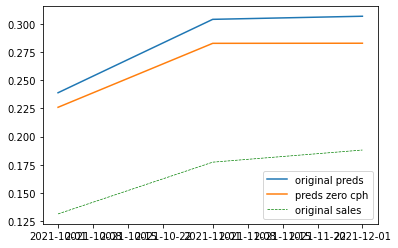

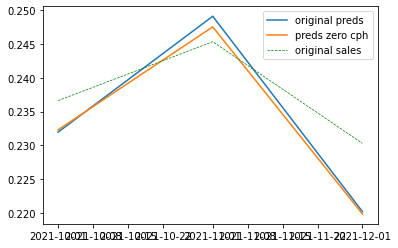

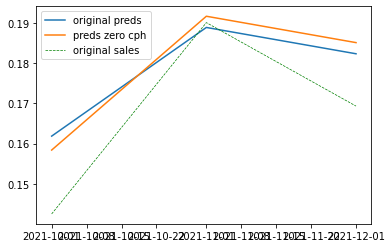

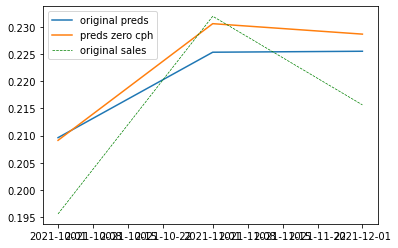

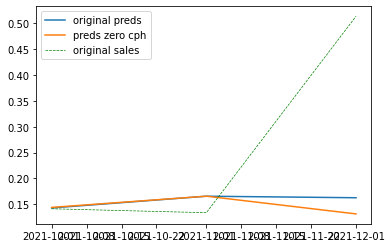

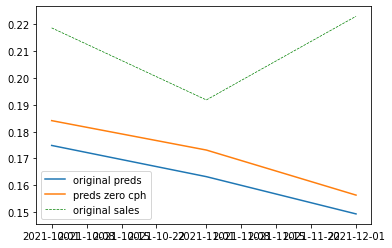

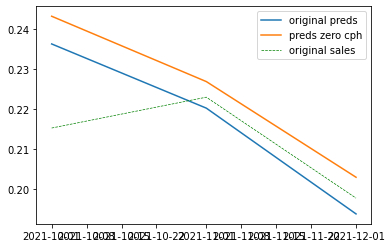

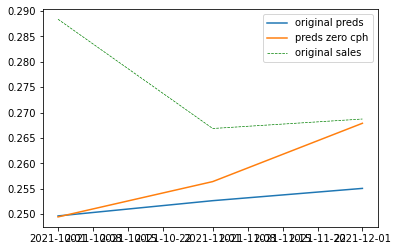

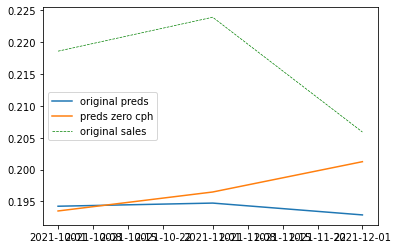

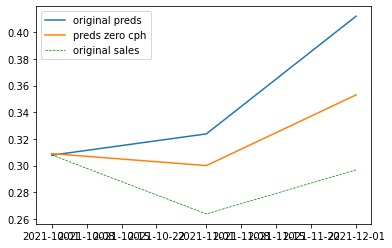

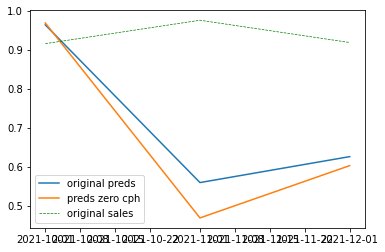

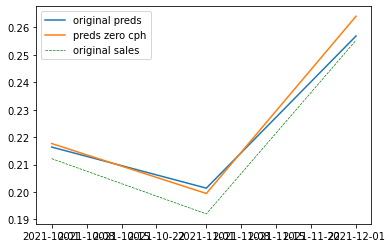

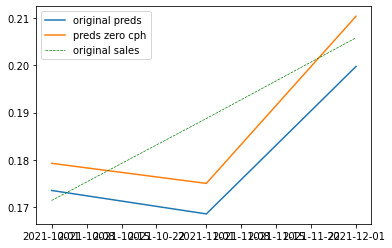

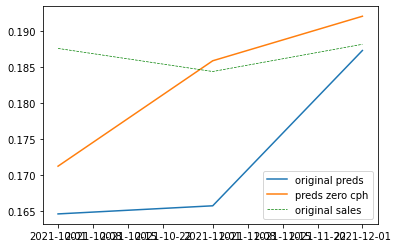

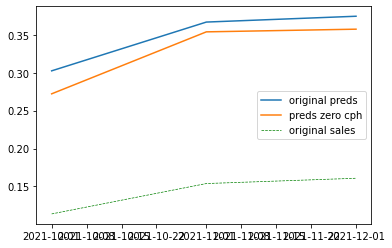

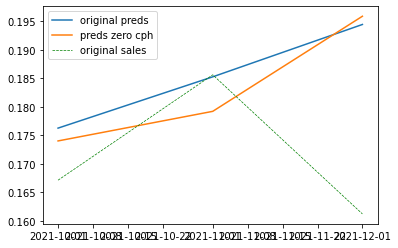

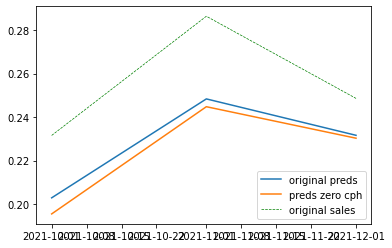

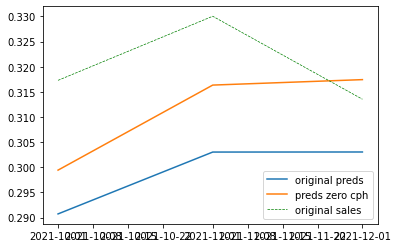

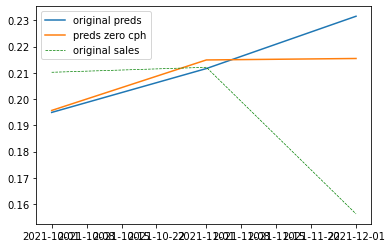

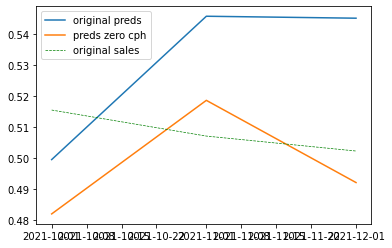

In [190]:
for asl in dfx.asl.unique()[0:20]:
    plt.plot(dfx[dfx.asl==asl].index,
            dfx[dfx.asl==asl].preds_original, label='original preds')
    plt.plot(dfx[dfx.asl==asl].index,
            dfx[dfx.asl==asl].preds_zero, label='preds zero cph')
    plt.plot(dfx[dfx.asl==asl].index,
            dfx[dfx.asl==asl].scaled_sales_per_hcp,
             ls='--', lw=.7, color='green',
             label='original sales')
    plt.legend()
    plt.show()

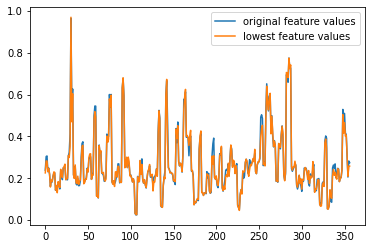

In [191]:
plt.plot(fc_means, label='original feature values')
plt.plot(fc_means_zero, label='lowest feature values')
#plt.plot(highest_mean_fc, label='highest feature values')
#plt.plot(absurd_mean_fc, label='absurd')
plt.legend()

### Return predictions from training set

In [ ]:
# not working atm. need more time to make that run...

In [74]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts_train = list(forecast_it)

fc_means_train = [forecasts_train[i].mean for i in range(len(forecasts_train))]
fc_means_train = np.concatenate(fc_means_train)

In [75]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts_train = list(forecast_it)

len(forecasts_train)

119

(array([[ 0.,  0.,  0.,  3.,  0., 12., 45., 36.,  4.,  0.],
        [ 0.,  0.,  0.,  1.,  3., 30., 41., 24.,  0.,  1.],
        [ 2.,  1.,  3.,  4., 16., 29., 26., 12.,  2.,  5.]]),
 array([0.08348083, 0.09674548, 0.11001013, 0.12327478, 0.13653943,
        0.14980409, 0.16306873, 0.17633337, 0.18959802, 0.20286268,
        0.21612732], dtype=float32),
 <a list of 3 BarContainer objects>)

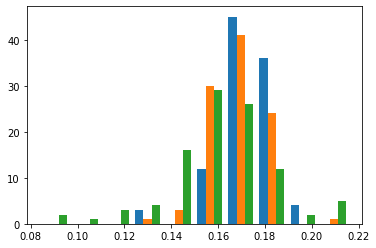

In [76]:
plt.hist(forecasts_train[2].samples)